# Post-processing of simulation results

This notebook compares the following simulation results:

- global Sherwood number
- local Sherwood number
- wake concentration

In [12]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

cases = ["CB{:1d}".format(i) for i in range(1, 5)]
print("Case names : ", cases)

data_path_sgs = "../data/32_cells/"
data_path_hybrid = "../openfoam/run/"
output_path = "../output/"

Case names :  ['CB1', 'CB2', 'CB3', 'CB4']


## Loading the data
### Global Sherwood numbers

In [43]:
sh_glob_hybrid = {}

names = ["time", "Sh_eff", "area"]

for case in cases:
    for sc in ["s1", "s2", "s3"]:
        path = data_path_hybrid + case + "_ref_1/globalSh_" + sc + ".csv"
        sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)

for sc in ["s1", "s2", "s3"]:
    path = data_path_hybrid + "CB4_ref_0/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    path = data_path_hybrid + "CB4_ref_2_parallel/globalSh_" + sc + ".csv"
    sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    #path = data_path_hybrid + "CB4_steady_ref_0/globalSh_" + sc + ".csv"
    #sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)
    #path = data_path_hybrid + "CB4_slip_ref_0/globalSh_" + sc + ".csv"
    #sh_glob_hybrid[path] = pd.read_csv(path, header=0, names=names)

In [46]:
sh_glob_sgs = {}

folders = ["{:s}_{:d}".format(case, sc) for case in cases for sc in [100, 1000, 10000]]
names = ["col{:1d}".format(col) for col in range(10)]
names[0] = "time"
names[2] = "Sh"
for folder in folders:
    path = data_path_sgs + "GlobalSh/{:s}/targetmarker_profile.dat".format(folder)
    sh_glob_sgs[folder] = pd.read_csv(path, sep=" ", header=None, names=names, usecols=["time", "Sh"])

## Mesh dependency hybrid approach

In [3]:
def sh_lochiel(re, sc):
    return 2.0/np.sqrt(np.pi) * np.sqrt(1.0 - 2.96/np.sqrt(re)) * np.sqrt(re*sc)

In [4]:
viscosity = np.array([2.18064e-2, 1.01347e-2, 6.11814e-3, 4.19665e-3])
rise_vel = []
for case in cases:
    log_path = output_path + case + "/log_file.pkl"
    log = pd.read_pickle(log_path)
    rise_vel.append(log[log.t > 7].ub_x.mean())
rise_vel = np.array(rise_vel)
reynolds = rise_vel/viscosity
for case, re in zip(cases, reynolds):
    print("Reynolds number for case {:s}: {:5.2f}".format(case, re))

Reynolds number for case CB1: 71.99
Reynolds number for case CB2: 243.03
Reynolds number for case CB3: 429.73
Reynolds number for case CB4: 569.31


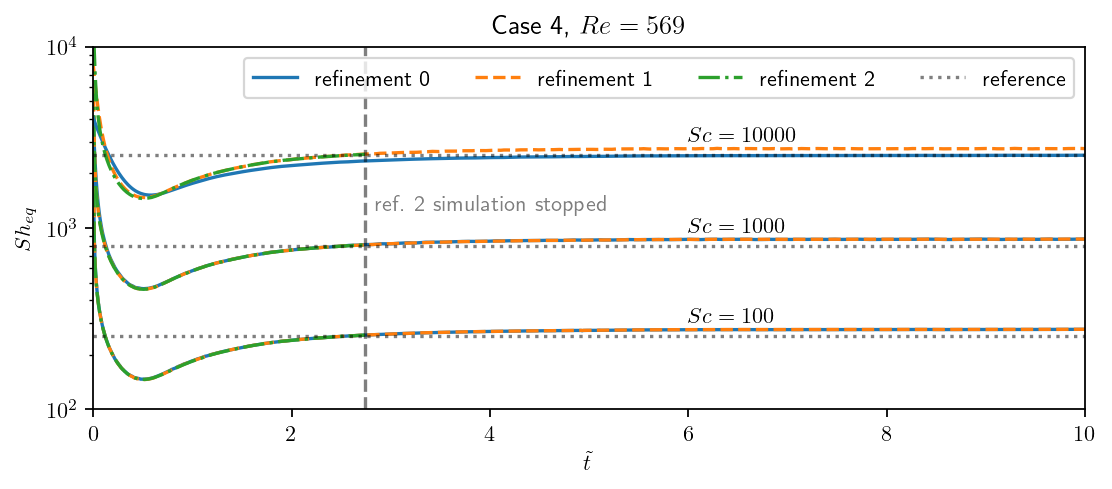

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
area_eq = np.pi * 3.0/360.0

schmidt = [100, 1000, 10000]
for i, sc in enumerate(["s1", "s2", "s3"]):
    ref_0 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_0/globalSh_" + sc + ".csv"]
    ref_1 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_1/globalSh_" + sc + ".csv"]
    ref_2 = sh_glob_hybrid[data_path_hybrid + "CB4_ref_2_parallel/globalSh_" + sc + ".csv"]
    sh_eq_0 = ref_0.Sh_eff*ref_0.area/area_eq
    sh_eq_1 = ref_1.Sh_eff*ref_1.area/area_eq
    sh_eq_2 = ref_2.Sh_eff*ref_2.area/area_eq
    sh_ref = sh_lochiel(reynolds[-1], schmidt[i])
    if i > 1:
        ax.plot(ref_0.time, sh_eq_0, color="C0", ls="-", label=r"refinement 0".format(schmidt[i]))
        ax.plot(ref_1.time, sh_eq_1, color="C1", ls="--", label=r"refinement 1".format(schmidt[i]))
        ax.plot(ref_2.time, sh_eq_2, color="C2", ls="-.", label=r"refinement 2".format(schmidt[i]))
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5, label="reference")
        ax.axvline(ref_2.time.values[-1], ls="--", color="k", alpha=0.5)
        ax.text(ref_2.time.values[-1]+0.1, 1250, "ref. 2 simulation stopped", alpha=0.5)
    else:
        ax.plot(ref_0.time, sh_eq_0, color="C0", ls="-")
        ax.plot(ref_1.time, sh_eq_1, color="C1", ls="--")
        ax.plot(ref_2.time, sh_eq_2, color="C2", ls="-.")
        ax.plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5)
        
    ax.text(6.0, sh_ref*1.2, r"$Sc={:4.0f}$".format(schmidt[i]))
    
ax.set_xlabel(r"$\tilde{t}$")
ax.set_ylabel(r"$Sh_{eq}$")
ax.set_yscale("log")
ax.set_xlim(0.0, 10.0)
ax.set_ylim(100, 10000)
ax.legend(ncol=4)
ax.set_title(r"Case 4, $Re={:2.0f}$".format(np.round(reynolds[-1], 0)))
plt.savefig(output_path + "sh_glob_mesh_dep_hybrid.pdf", bbox_inches="tight")

## Comparison between hybrid approach and SGS model

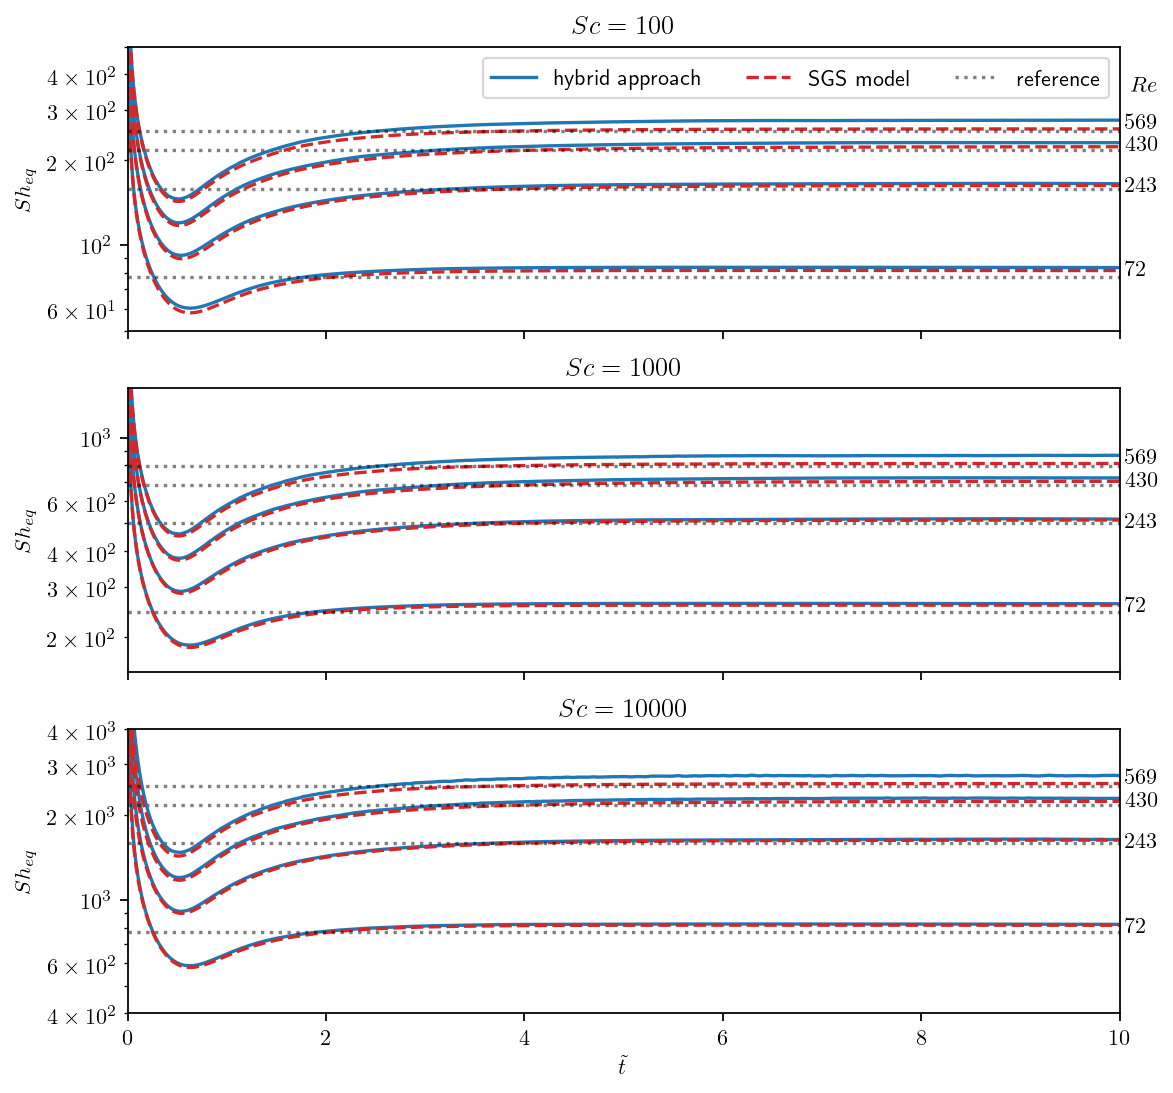

In [90]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

time_sgs = np.linspace(0.0, 10.0, 1e5)
l_bounds = [50, 150, 400]
u_bounds = [500, 1500, 4000]

for i, (sc, sc_num) in enumerate(zip(["s1", "s2", "s3"], [100, 1000, 10000])):
    for j, case in enumerate(cases):
        # hybrid approach
        data = sh_glob_hybrid[data_path_hybrid + case + "_ref_1/globalSh_" + sc + ".csv"]
        sh_eq = data.Sh_eff.values * data.area.values / area_eq
        # sgs model
        data_sgs = sh_glob_sgs["{:s}_{:d}".format(case, sc_num)]
        # correlation
        sh_ref = sh_lochiel(reynolds[j], schmidt[i])
        if i==0 and j==0:
            axarr[i].plot(data.time, sh_eq, color="C0", ls="-", label=r"hybrid approach")
            axarr[i].plot(data_sgs.time, data_sgs.Sh, color="C3", ls="--", label=r"SGS model")
            axarr[i].plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5, label="reference")
        else:
            axarr[i].plot(data.time, sh_eq, color="C0", ls="-")
            axarr[i].plot(data_sgs.time, data_sgs.Sh, color="C3", ls="--")
            axarr[i].plot([0.0, 10.0], [sh_ref, sh_ref], color="k", ls=":", alpha=0.5)
        axarr[i].text(10.05, 0.94*sh_eq[-1], r"${:3.0f}$".format(np.round(reynolds[j], 0)))
    axarr[i].set_ylabel(r"$Sh_{eq}$")
    axarr[i].set_yscale("log")
    axarr[i].set_xlim(0.0, 10.0)
    axarr[i].set_ylim(l_bounds[i], u_bounds[i])
    axarr[i].set_title(r"$Sc={:4.0f}$".format(schmidt[i]))
    
axarr[0].text(10.1, 350, r"$Re$")
axarr[0].legend(ncol=3, loc=0)
axarr[-1].set_xlabel(r"$\tilde{t}$")
plt.savefig(output_path + "sh_glob_comparison.pdf", bbox_inches="tight")